# Import Library

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ipywidgets import widgets
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from io import BytesIO
import shutil
import re
import random

In [3]:
filePath = 'dataset/'

fileName = []
tag = []
full_path = []
labels = []
for path, subdirs, files in os.walk(filePath):
    for name in files:
        full_path.append(os.path.join(path, name))
        tag.append(path.split('/')[-1])
        fileName.append(name)

In [4]:
dataset_path = 'dataset/'

# Lists to store data
file_names = []
labels = []
full_paths = []

# Traverse the dataset directory
for class_folder in sorted(os.listdir(dataset_path)):
    class_folder_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_folder_path):  # Check if it's a directory
        for image_file in os.listdir(class_folder_path):
            full_paths.append(os.path.join(class_folder_path, image_file))
            file_names.append(image_file)
            labels.append(class_folder)  # Use folder name as class label

# Create a DataFrame
data = {
    'FileName': file_names,
    'ClassLabel': labels,
    'FullPath': full_paths
}
df = pd.DataFrame({"FileName": file_names, 'ClassLabel':labels, 'FullPath':full_path})
df.groupby(['ClassLabel']).size()


ClassLabel
ayam           698
brokoli        600
ikan           616
kambing        600
kembang kol    600
kentang        600
kol            600
labu           600
mentimun       600
paprika        600
sapi           620
tahu           660
telur          648
tempe          699
tomat          600
udang          600
wortel         600
dtype: int64

In [5]:
df.head()

,FileName,ClassLabel,FullPath
0,ayam01.jpg,ayam,dataset/ayam\ayam01.jpg
1,ayam10.jpeg,ayam,dataset/ayam\ayam10.jpeg
2,ayam100.png,ayam,dataset/ayam\ayam100.png
3,ayam101.png,ayam,dataset/ayam\ayam101.png
4,ayam102.jpg,ayam,dataset/ayam\ayam102.jpg


In [6]:
x = df['FullPath'].values
y = df['ClassLabel'].values

# x adalah gambar dan y adalah label
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=300)

# Pertama, bagi data menjadi train dan temp (yang akan dibagi lagi menjadi validasi dan testing)
for train_index, temp_index in sss.split(x, y):
    X_train, X_temp = x[train_index], x[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# Kedua, bagi temp menjadi validation dan testing
sss_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=300)
for val_index, test_index in sss_temp.split(X_temp, y_temp):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]


In [7]:
print(f"Training size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Training size: 7378
Validation size: 1581
Test size: 1582


In [8]:
DIMENSION = (224, 224, 3)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCH = 15
NUM_CLASSES = 17

# Image Preprocessing

In [9]:
#apply laplacian filter
def PreProcess(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)
    blurred = cv2.GaussianBlur(img_rgb, (3, 3), 0)
    laplace = cv2.Laplacian(blurred, cv2.CV_64F)
    laplace_abs = cv2.convertScaleAbs(laplace)
    sharpened = cv2.convertScaleAbs(img_rgb - laplace_abs)

    plt.subplots(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(sharpened)
    plt.title("Sharpened")

    plt.show()



In [10]:
def PreProcess1(path):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    laplace = cv2.Laplacian(img_rgb, cv2.CV_64F, ksize=3)
    laplace_abs = cv2.convertScaleAbs(laplace)

    sharpened = cv2.convertScaleAbs(img_rgb - laplace_abs)

    
    # Display results
    plt.subplots(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb, 0)
    plt.title("Original")
    
    plt.subplot(1,2,2)
    plt.imshow(sharpened, 0)
    plt.title("Sharpened")
    
    plt.show()
    
    return sharpened

In [11]:
def ImagePreprocess1(path):
    # Load the image 
    image = cv2.imread(path) 
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img_rgb, IMG_SIZE)

    # Create the sharpening kernel 
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 

    # Sharpen the image 
    sharpened_image = cv2.filter2D(img_resize, -1, kernel) 
    return sharpened_image

In [12]:
preprocessed_img_train = [ImagePreprocess1(path) for path in X_train]
X_train_preprocessed = np.array(preprocessed_img_train, dtype=np.float32)

preprocessed_img_val = [ImagePreprocess1(path) for path in X_val]
X_val_preprocessed = np.array(preprocessed_img_val, dtype=np.float32)

preprocessed_img_test = [ImagePreprocess1(path) for path in X_test]
X_test_preprocessed = np.array(preprocessed_img_test, dtype=np.float32)

In [13]:
def changeLabel(name):
    if name == "ayam":
        return 0
    elif name == "brokoli":
        return 1
    elif name == "ikan":
        return 2
    elif name == "kambing":
        return 3
    elif name == "kembang kol":
        return 4
    elif name == "kentang":
        return 5
    elif name == "kol":
        return 6
    elif name == "labu":
        return 7
    elif name == "mentimun":
        return 8
    elif name == "paprika":
        return 9
    elif name == "sapi":
        return 10
    elif name == "tahu":
        return 11
    elif name == "telur":
        return 12
    elif name == "tempe":
        return 13
    elif name == "tomat":
        return 14
    elif name == "udang":
        return 15
    elif name == "wortel":
        return 16


In [14]:
num_labels = np.array([changeLabel(i) for i in y_train], dtype=np.float32)
val_labels = np.array([changeLabel(j) for j in y_val], dtype=np.float32)
test_labels = np.array([changeLabel(k) for k in y_test], dtype=np.float32)
y_train_one_hot = to_categorical(num_labels, num_classes=17)
y_val_one_hot = to_categorical(val_labels, num_classes=17)
y_test_one_hot = to_categorical(test_labels, num_classes=17)

In [15]:
num_labels

array([ 5., 14.,  9., ...,  8.,  8., 10.], dtype=float32)

In [16]:
validation_img = (np.array(preprocessed_img_val), y_val_one_hot)

In [17]:
# Define fill mode.
FILL_MODE = 'nearest'

# Create the augmentation model.
data_augmentation = tf.keras.Sequential([
    # Add the augmentation layers
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE)
    ])

# Train into model  

In [18]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=DIMENSION,
    include_top=False,
    weights='imagenet'
)

# Fine-tuning: Freeze the first 30 layers, allow the rest to train
for layer in base_model.layers[:30]:
    layer.trainable = False

model = models.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),  # Normalize the image
    base_model,  # Input layer
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),  # Flatten the output for dense layers
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Fully connected layer
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(17, activation='softmax')  # Output layer (17 classes)
])


In [19]:
model.build(input_shape=(None, *DIMENSION))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │         1,105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,341,329 (8.93 MB)

 Trainable params: 2,287,553 (8.73 MB)

 Non-trainable params: 53,776 (210.06 KB)

In [20]:
print(X_train_preprocessed.shape)
print(X_test_preprocessed.shape)


(7378, 224, 224, 3)
(1582, 224, 224, 3)


In [21]:
model.compile(
    optimizer=optimizers.Adam(1e-4), 
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [22]:
try:
	model.evaluate(X_train_preprocessed, y_train_one_hot, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(X_train_preprocessed, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (7378, 17)


In [23]:
print(f'Input shape: {model.input_shape}')
print(f'Output shape: {model.output_shape}')

Input shape: (None, 224, 224, 3)
Output shape: (None, 17)


In [24]:
features = np.array(validation_img[0])  # Convert features list to a NumPy array
labels = np.array(validation_img[1])    # Convert labels list to a NumPy array

print(features.shape)  # Features shape
print(labels.shape)    # Labels shape

(1581, 224, 224, 3)
(1581, 17)


In [ ]:
from ipywidgets import widgets
from io import BytesIO

uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    try:
        image = tf.keras.utils.load_img(file, target_size=(224, 224))
        image = tf.keras.utils.img_to_array(image)
        image = np.expand_dims(image, axis=0)

        prediction = model.predict(image, verbose=0)[0]

        with out:
            print(f'\nmodel output: {prediction}')
            prediction_index = np.argmax(prediction)
            classes = ["ayam", "brokoli", "ikan", "kambing", "kembang kol", "kentang", "kol", "labu", "mentimun", "paprika", "sapi", "tahu", "telur", "tempe", "tomat", "udang", "wortel"]
            predicted_class = classes[prediction_index]
            print(f'{filename} is {predicted_class}')
    except Exception as e:
        with out:
            print(f"Error processing {filename}: {str(e)}")

def on_upload_change(change):
    items = change.new
    for item in items: # Loop if there is more than one file uploaded
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

In [25]:
os.makedirs('saved_models_v3_image_2', exist_ok=True)
checkpoint_filepath = 'saved_models_v3_image_2/weights-improvment-{epoch:02d}-{loss:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='loss',
    verbose=1,
    mode='min',
    save_best_only=True
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_preprocessed, 
    y_train_one_hot, 
    epochs=EPOCH, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_val_preprocessed, y_val_one_hot),
    callbacks=[model_checkpoint_callback, early_stop]
)

Epoch 1/15
239/239 [==============================] - ETA: 0s - loss: 2.4789 - accuracy: 0.6361
Epoch 1: loss improved from inf to 2.47887, saving model to saved_models_v3_image_2\weights-improvment-01-2.48.keras
239/239 [==============================] - 177s 691ms/step - loss: 2.4789 - accuracy: 0.6361 - val_loss: 1.7776 - val_accuracy: 0.8297
Epoch 2/15
239/239 [==============================] - ETA: 0s - loss: 1.6452 - accuracy: 0.8618
Epoch 2: loss improved from 2.47887 to 1.64523, saving model to saved_models_v3_image_2\weights-improvment-02-1.65.keras
239/239 [==============================] - 160s 671ms/step - loss: 1.6452 - accuracy: 0.8618 - val_loss: 1.5831 - val_accuracy: 0.8597
Epoch 3/15
239/239 [==============================] - ETA: 0s - loss: 1.4253 - accuracy: 0.9021
Epoch 3: loss improved from 1.64523 to 1.42532, saving model to saved_models_v3_image_2\weights-improvment-03-1.43.keras
239/239 [==============================] - 171s 715ms/step - loss: 1.4253 - accurac

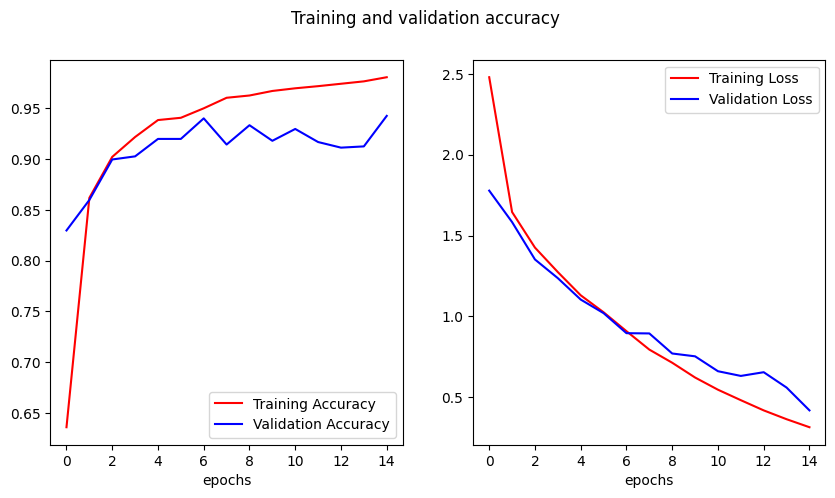

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
# model.save("model_v3_acc_98.04_loss_0.33.keras")

In [25]:
model = load_model("model_v3_acc_98.04_loss_0.33.keras")

In [36]:
y_pred = model.predict(X_test_preprocessed)

50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 493ms/step


### Confusion Matrix

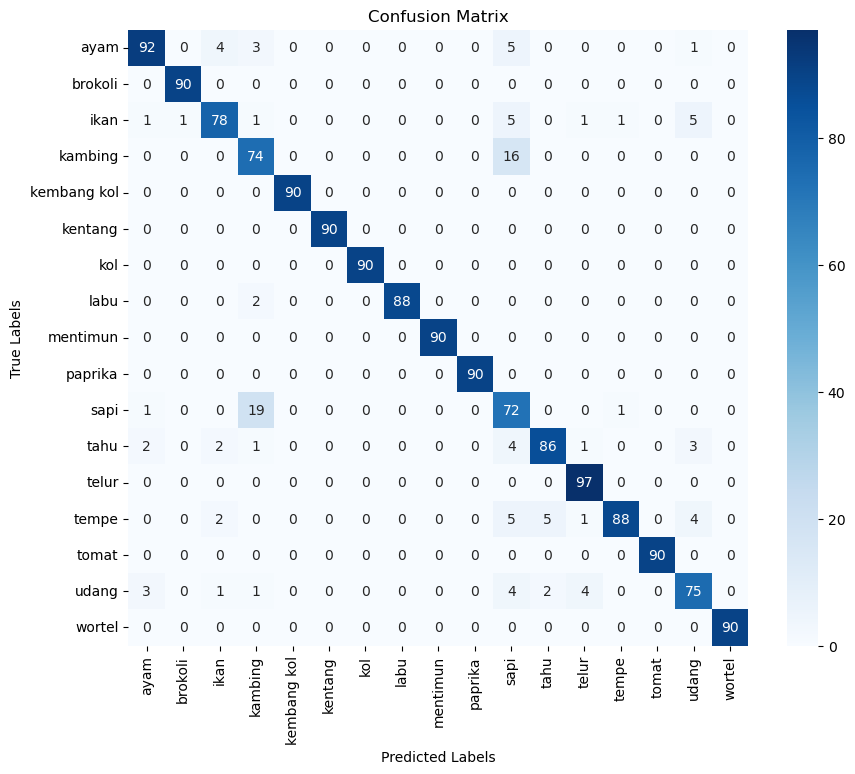

In [37]:
classes = ["ayam", "brokoli", "ikan", "kambing", "kembang kol", "kentang", "kol", "labu", "mentimun", "paprika", "sapi", "tahu", "telur", "tempe", "tomat", "udang", "wortel"] 

y_true = np.argmax(y_test_one_hot, axis=1)  # Ubah one-hot ke label numerik
y_pred = np.argmax(y_pred, axis=1)     # Ubah probabilitas ke label numerik

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [38]:
# Hitung laporan metrik evaluasi
report = classification_report(y_true, y_pred, target_names=classes)

print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

        ayam       0.93      0.88      0.90       105
     brokoli       0.99      1.00      0.99        90
        ikan       0.90      0.84      0.87        93
     kambing       0.73      0.82      0.77        90
 kembang kol       1.00      1.00      1.00        90
     kentang       1.00      1.00      1.00        90
         kol       1.00      1.00      1.00        90
        labu       1.00      0.98      0.99        90
    mentimun       1.00      1.00      1.00        90
     paprika       1.00      1.00      1.00        90
        sapi       0.65      0.77      0.71        93
        tahu       0.92      0.87      0.90        99
       telur       0.93      1.00      0.97        97
       tempe       0.98      0.84      0.90       105
       tomat       1.00      1.00      1.00        90
       udang       0.85      0.83      0.84        90
      wortel       1.00      1.00      1.00        90

  

In [39]:
correct = np.sum(y_true == y_pred)  # Hitung jumlah prediksi benar
accuracy = correct / len(y_true)   # Hitung akurasi
print(f"Akurasi: {accuracy:.2%}")

Akurasi: 92.92%


## cek isi variable

In [40]:
for y_pred in predictions:
    idx = np.argmax(y_pred)
    print(classes[idx])

ikan
udang
ikan
telur
telur
mentimun
wortel
kembang kol
telur
udang
udang
telur
kembang kol
wortel
tomat
brokoli
telur
udang
ikan
kembang kol
telur
udang
tempe
ikan
kembang kol
udang
kembang kol
ikan
kembang kol
tomat
udang
kembang kol
udang
udang
labu
telur
udang
tempe
wortel
brokoli
kembang kol
ikan
udang
mentimun
telur
kembang kol
wortel
mentimun
ikan
kembang kol
udang
mentimun
kembang kol
udang
wortel
ikan
kembang kol
wortel
tempe
kentang
telur
kembang kol
udang
telur
kembang kol
kentang
udang
udang
tomat
kembang kol
udang
telur
kentang
tomat
udang
mentimun
telur
ikan
kambing
tahu
mentimun
tomat
kembang kol
brokoli
wortel
telur
tempe
brokoli
telur
kembang kol
ikan
telur
udang
telur
udang
kembang kol
tomat
telur
udang
kembang kol
kembang kol
udang
kembang kol
udang
kembang kol
kembang kol
kembang kol
telur
ikan
udang
udang
telur
kentang
kembang kol
udang
tempe
mentimun
mentimun
udang
kembang kol
udang
udang
udang
tomat
udang
telur
telur
udang
mentimun
telur
udang
udang
udang
udang
k

In [41]:
for label in y_train:
    print(label)

kentang
tomat
paprika
tempe
kambing
udang
wortel
kol
ikan
tomat
tahu
udang
paprika
sapi
labu
tomat
ayam
tempe
telur
tahu
udang
tomat
kentang
tahu
kol
wortel
paprika
brokoli
mentimun
kol
tomat
mentimun
kambing
kol
tomat
sapi
tahu
kentang
kambing
paprika
kol
telur
mentimun
tomat
ayam
mentimun
tahu
kol
mentimun
wortel
kentang
mentimun
udang
wortel
tomat
brokoli
tahu
kentang
tahu
sapi
labu
wortel
tahu
tahu
mentimun
mentimun
telur
tahu
sapi
tempe
mentimun
ayam
kambing
ikan
udang
paprika
telur
ikan
sapi
brokoli
paprika
ikan
mentimun
kambing
wortel
wortel
wortel
sapi
tahu
kambing
tomat
labu
tomat
tempe
paprika
kol
paprika
udang
tomat
paprika
kambing
tomat
paprika
tahu
mentimun
ayam
kembang kol
tahu
brokoli
mentimun
tempe
labu
ikan
wortel
telur
tomat
mentimun
paprika
kambing
paprika
tomat
kembang kol
tempe
ikan
tempe
kambing
kembang kol
kembang kol
labu
tempe
ikan
tempe
kembang kol
kembang kol
tomat
wortel
tahu
paprika
sapi
tomat
telur
udang
ikan
sapi
paprika
kembang kol
brokoli
kembang kol
ud

In [42]:
classes = ["ayam", "brokoli", "ikan", "kambing", "kembang kol", "kentang", "kol", "labu", "mentimun", "paprika", "sapi", "tahu", "telur", "tempe", "tomat", "udang", "wortel"] 

correct = 0
for y_pred, y_true in zip(predictions, y_train):
    pred_idx = np.argmax(y_pred)  # Indeks prediksi
    if pred_idx == y_true:  # Cocokkan dengan label asli
        correct += 1
    print("pred idx: " + classes[pred_idx])  # Konversi pred_idx ke string
    print("y true: " + str(y_true))      # Konversi y_true ke string

accuracy = correct / len(y_train)
print(f"Akurasi: {accuracy:.2%}")


pred idx: ikan
y true: kentang
pred idx: udang
y true: tomat
pred idx: ikan
y true: paprika
pred idx: telur
y true: tempe
pred idx: telur
y true: kambing
pred idx: mentimun
y true: udang
pred idx: wortel
y true: wortel
pred idx: kembang kol
y true: kol
pred idx: telur
y true: ikan
pred idx: udang
y true: tomat
pred idx: udang
y true: tahu
pred idx: telur
y true: udang
pred idx: kembang kol
y true: paprika
pred idx: wortel
y true: sapi
pred idx: tomat
y true: labu
pred idx: brokoli
y true: tomat
pred idx: telur
y true: ayam
pred idx: udang
y true: tempe
pred idx: ikan
y true: telur
pred idx: kembang kol
y true: tahu
pred idx: telur
y true: udang
pred idx: udang
y true: tomat
pred idx: tempe
y true: kentang
pred idx: ikan
y true: tahu
pred idx: kembang kol
y true: kol
pred idx: udang
y true: wortel
pred idx: kembang kol
y true: paprika
pred idx: ikan
y true: brokoli
pred idx: kembang kol
y true: mentimun
pred idx: tomat
y true: kol
pred idx: udang
y true: tomat
pred idx: kembang kol
y tr